In [45]:
import os
from IPython.display import Image, display
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import random
import starfile
import pandas as pd
import numpy as np
import mrcfile
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
from scipy.ndimage import gaussian_filter
import pathlib

mirroted_strategy = tf.distribute.MirroredStrategy()

project_dir = '20s_10025'
meta_data_path = f'{project_dir}/Refine3D/job026/run_data.star'

meta_data = starfile.read(meta_data_path)

input_dir = meta_data['rlnImageName'][0].split('@')[-1].split('/')[:-1]
input_dir = f"{project_dir}/{'/'.join(input_dir)}"

target_dir = f'train_particleSeg/{project_dir}/mask_mrcs/'

img_size = (400, 400)
num_classes = 3
batch_size = 32

target_img_paths=list(pathlib.Path(target_dir).glob("*.mrcs"))

input_img_paths = []
new_meta = []
for target_path in target_img_paths:
    checked_input_path = list(pathlib.Path(input_dir).glob(target_path.name))[0]
    try:
        input_img_paths.append(checked_input_path)
        new_meta.append( meta_data[meta_data['rlnImageName'].str.contains(target_path.name)])
        #print('Added')
    except Exception as e:
        print(e)
        print(target_path.name)
        print('Not match')
new_meta = pd.concat(new_meta)
for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


KeyboardInterrupt: 

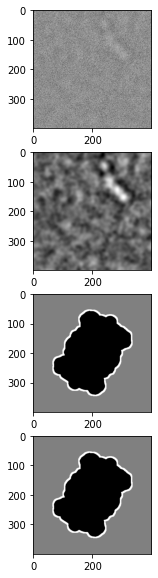

In [2]:
np.set_printoptions(threshold=sys.maxsize)

mrcs_index = 6
particle_index = 12
# Display input image #7

with mrcfile.open(input_img_paths[mrcs_index]) as mrc:
    raw_particles = mrc.data[particle_index]
with mrcfile.open(target_img_paths[mrcs_index]) as mrc:
    mask = mrc.data[particle_index]
binned_mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].imshow(raw_particles, cmap='gray')
ax[1].imshow(gaussian_filter(raw_particles, sigma=5), cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[3].imshow(binned_mask, cmap='gray')

In [40]:
class t20s_particles(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, meta):
        self.batch_size = batch_size
        self.img_size = img_size
        self.meta = meta

    def __len__(self):
        return len(self.meta) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, item in enumerate(self.meta[i: i+ self.batch_size].iterrows()):
            shift_percent = 0.6
            shift_w = random.uniform(0, shift_percent)
            shift_y = random.uniform(0, shift_percent)
            input_path = f"{project_dir}/{item[1]['rlnImageName'].split('@')[-1]}"
            mask_path = f"{target_dir}{item[1]['rlnImageName'].split('/')[-1]}"
            particle_idx = int(item[1]['rlnImageName'].split('@')[0]) -1
            with mrcfile.open(input_path) as mrc:
                img = mrc.data[particle_idx]
            with mrcfile.open(mask_path) as mrc:
                mask = mrc.data[particle_idx]
            img = cv2.resize(img, dsize=self.img_size, interpolation=cv2.INTER_NEAREST)
            img = np.stack((img,)*3, axis=-1)
            #img = tf.keras.preprocessing.image.random_shift(img, wrg=shift_w, hrg=shift_y, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
            x[j] = img
            mask = cv2.resize(mask, dsize=self.img_size, interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, 2)
            #print(mask.shape)
            #mask = tf.keras.preprocessing.image.random_shift(mask, wrg=shift_w, hrg=shift_y, row_axis=0, col_axis=1,channel_axis=2, fill_mode='nearest')
            y[j] = mask
        return x, y

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


In [41]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
with mirroted_strategy.scope():
    model = get_model(img_size, num_classes)
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[UpdatedMeanIoU(num_classes=3)])
#model = keras.models.load_model("oxford_segmentation.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 200, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [42]:

# Split our img paths into a training and a validation set
val_samples_size = 10000
new_meta_shuffle = new_meta#.sample(frac=1)
train_meta = new_meta_shuffle[:-val_samples_size]
val_meta = new_meta_shuffle[-val_samples_size:]

# Instantiate data Sequences for each split
train_gen = t20s_particles(
    batch_size, img_size, train_meta)
val_gen = t20s_particles(batch_size, img_size, val_meta)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


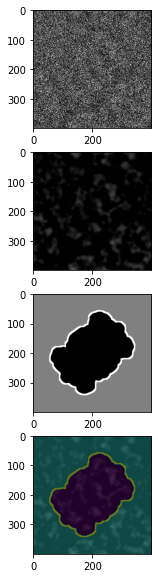

In [43]:
i = 50
x,y = train_gen.__getitem__(0)
fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].imshow(x[i], cmap='gray')
ax[1].imshow(gaussian_filter(x[i], sigma=5), cmap='gray')
ax[2].imshow(y[i], cmap='gray')
ax[3].imshow(gaussian_filter(x[i], sigma=5), cmap='gray')
ax[3].imshow(y[i], alpha=0.5)

In [44]:
#opt = keras.optimizers.Adam(learning_rate=5e-4)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("models/1027_particle_segmentation.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Train the model, doing validation at the end of each epoch.
epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2021-10-27 17:50:23.196709: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_26324"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  ke

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1


2021-10-27 17:50:37.079834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-27 17:50:37.668985: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-10-27 17:50:38.331322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-10-27 17:50:38.796513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-27 17:50:39.414877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-10-27 17:50:40.186741: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_1_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-27 17:50:40.187159: W tensorflow/core/common_r

ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,128,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node gradient_tape/replica_1/model/conv2d_6/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp/_136]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,128,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node gradient_tape/replica_1/model/conv2d_6/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[32,128,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node gradient_tape/replica_1/model/conv2d_6/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/else/_1179/confusion_matrix/assert_less_1/Assert/AssertGuard/Assert/data_2/_190]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_41584]

Function call stack:
train_function -> train_function -> train_function


step 0 next 267
2021-10-27 17:50:50.835293: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] Free  at 7fc105950800 of size 102400000 by op UNUSED action_count 94534395546989 step 0 next 68
2021-10-27 17:50:50.835297: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] InUse at 7fc10baf8800 of size 163840000 by op model/conv2d_transpose_7/conv2d_transpose action_count 94534395548987 step 14345780936614968336 next 271
2021-10-27 17:50:50.835302: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] InUse at 7fc115738800 of size 327680000 by op model/add_5/add-1-TransposeNHWCToNCHW-LayoutOptimizer action_count 94534395548938 step 14345780936614968336 next 198
2021-10-27 17:50:50.835306: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] InUse at 7fc128fb8800 of size 655360000 by op model/conv2d_7/Conv2D action_count 94534395548946 step 14345780936614968336 next 210
2021-10-27 17:50:50.835310: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] InUse at 7fc1500b8800 o

In [ ]:
# val_gen = t20s_particles(batch_size, img_size, val_input_img_paths[:200], val_target_img_paths[:200])
# val_preds = model.predict(val_gen)

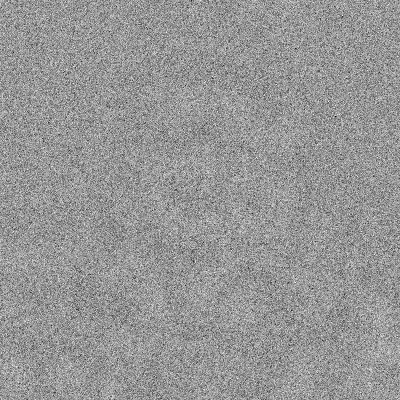

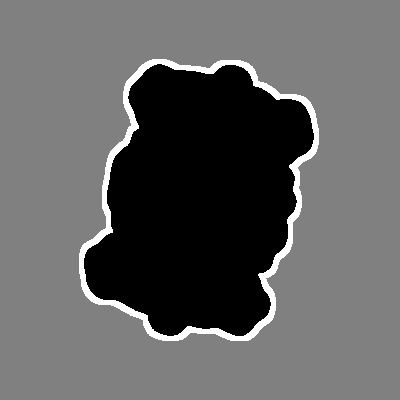

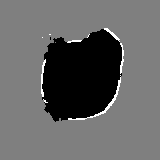

In [17]:
# def display_mask(i):
#     """Quick utility to display a model's prediction."""
#     mask = np.argmax(val_preds[i], axis=-1)
#     mask = np.expand_dims(mask, axis=-1)
#     img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
#     display(img)


# # Display results for validation image #10
# i = 5

# # Display input image
# display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
# img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

# # Display mask predicted by our model
# display_mask(i)